In this notebook, we load the features which we extracted and stored in previous notebook. Then we apply various clssifying models and perform validation and chek theier performace using various metrics.

# Loading the features dataset

In [2]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

In [3]:
#Read all Files into 'data' variable

def ReadFeaturesFile(csv_dir):
    data=None
    for csv in glob.glob(csv_dir+'*_features.csv'):
        df=pd.read_csv(csv)
        df['genre']=os.path.basename(csv).split('_')[0]
        if data is None:
            data=df
        else:
            data=data.append(df,ignore_index=True)
    return data

# Reading the dataset having 20 MFCC + 6 other parameters
data=ReadFeaturesFile('mfcc_20/')

In [4]:
params=list(data[0:0].columns[1:])

In [5]:
# Mapping gnere names with unique numbers

genre_mapper={k[1]:k[0] for k in zip(range(len(data['genre'].unique())),sorted(data['genre'].unique())) }
data_mapped=data.copy();
data_mapped['genre']=data_mapped['genre'].map(genre_mapper)
data_mapped.head()

file      mfcc_1  ...       rms  genre
0  genres/blues/blues.00000.wav -113.570648  ...  0.130228      0
1  genres/blues/blues.00001.wav -207.501694  ...  0.095948      0
2  genres/blues/blues.00002.wav  -90.722595  ...  0.175570      0
3  genres/blues/blues.00003.wav -199.544205  ...  0.141093      0
4  genres/blues/blues.00004.wav -160.337708  ...  0.091529      0

[5 rows x 28 columns]

### Some plotting to explore the data and see any cross correlations

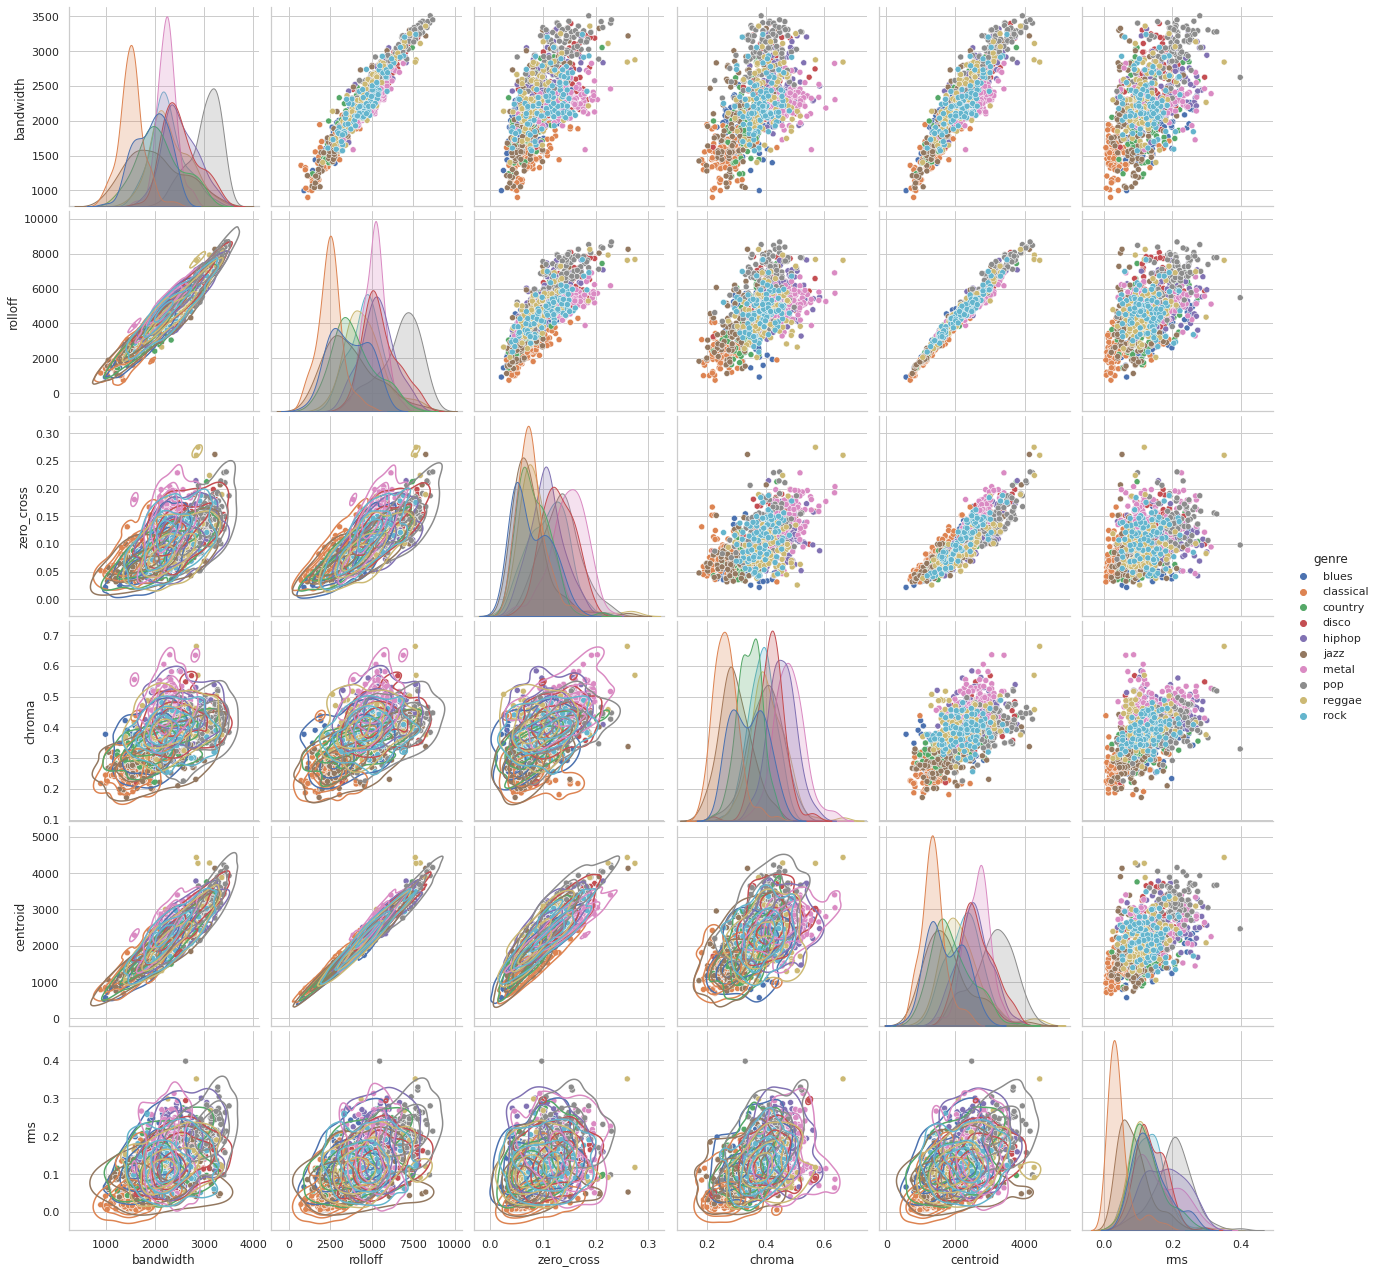

In [8]:
# Scatter plot among non-MFCC parameters

sns.set_style("whitegrid");
g=sns.pairplot(data[params[-7:]], hue="genre", height=3);
g.map_lower(sns.kdeplot, levels=4, color=".2")
plt.show()

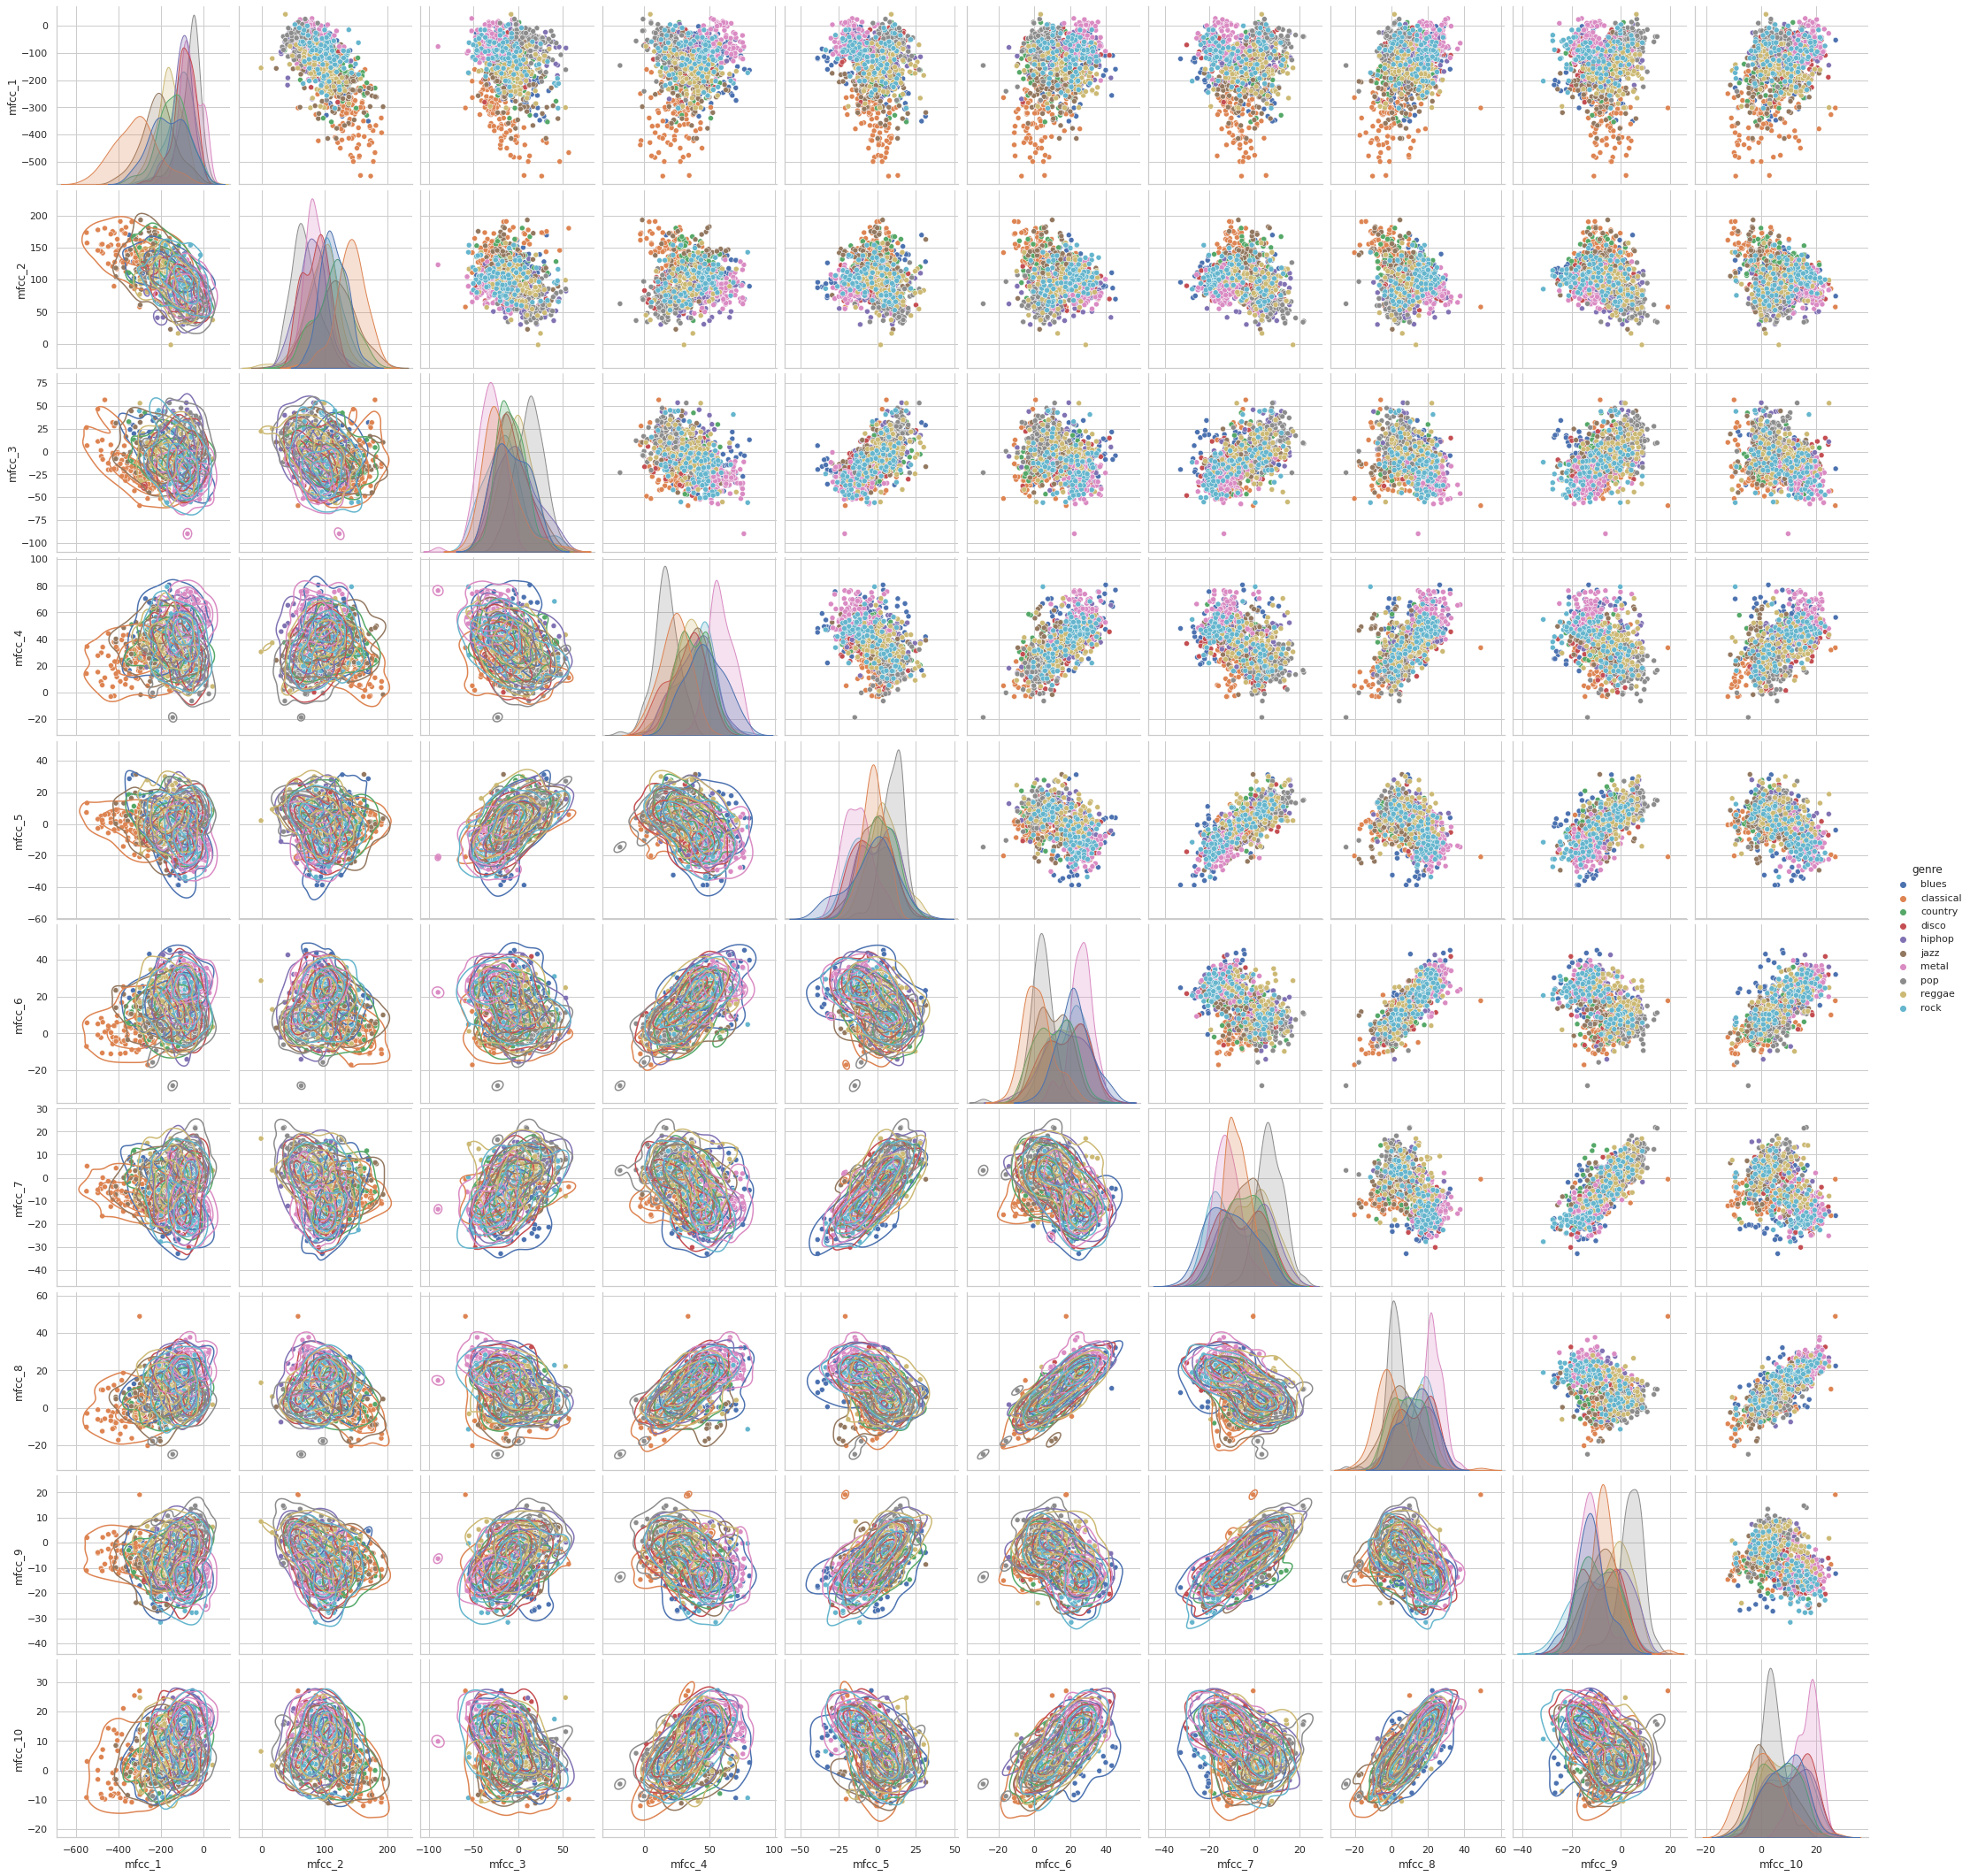

In [9]:
# Scatter plot among first 10 MFCC parameters

sns.set_style("whitegrid");
g=sns.pairplot(data[params[list(range(10))+[-1]]], hue="genre", height=3);
g.map_lower(sns.kdeplot, levels=4, color=".2")
plt.show()

# Build various models and perform validation check

### Function for cross-validation function and plotting metrics

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def cross_validate(X,y, pipe, label='', silent=False):
    # X - X data array
    # y - y vector
    # label - label to add in plots
    # silent - to supress prints and plots

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,shuffle=True, random_state = 100)
    
    accs=pd.DataFrame(columns=['Overall']+sorted(list(genre_mapper.keys())))
    TrueVsPred=pd.DataFrame(columns=sorted(list(genre_mapper.keys())), index=sorted(list(genre_mapper.keys()))).fillna(0)
    genre_rank={g:[] for g in genre_mapper.keys()}
    
    kfold = StratifiedKFold(5,shuffle=True,random_state = 440)
    for train_index,test_index in kfold.split(X_train,y_train):
        X_train_train,X_train_test = X_train.iloc[train_index],X_train.iloc[test_index]
        y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]

        pipe_clone = clone(pipe)
        
        pipe_clone.fit(X_train_train,y_train_train)

        pred = pipe_clone.predict(X_train_test)

        proba=pipe_clone.predict_proba(X_train_test)
        proba_rank=proba.copy()
        for row in proba_rank:
            row[np.argsort(row)[::-1]]=range(1,len(row)+1)
        proba_rank[proba<0.05]=len(row)
        
        tmp_acc={}
        tmp_acc['Overall']=accuracy_score(y_train_test,pred)
        tmp_TVP=pd.DataFrame().reindex_like(TrueVsPred)
        for k in genre_mapper.keys():
            tmp_index=y_train_test==genre_mapper[k]
            tmp_acc[k]=accuracy_score(y_train_test[tmp_index],pred[tmp_index])
            tmp_counts = np.array([list(pred[tmp_index]).count(genre_mapper[k2]) for k2 in genre_mapper.keys()])
            tmp_TVP.loc[genre_mapper.keys(), k] = tmp_counts/tmp_counts.sum()
            genre_rank[k]=genre_rank[k] + list(proba_rank[tmp_index,genre_mapper[k]].ravel())
        accs=accs.append(tmp_acc,ignore_index=True)
        TrueVsPred=TrueVsPred.add(tmp_TVP)
    TrueVsPred=TrueVsPred/len(accs)

    pipe_clone = clone(pipe)
    pipe_clone.fit(X_train,y_train)
    test_pred=pipe_clone.predict(X_test)
    test_acc=accuracy_score(y_test,test_pred)

    if not silent:
        print('Cross validation accuracies:')
        print(accs.mean())
        print("Overall accuracy on test set is ",test_acc)

        plt.figure(figsize=(10,4))
        plt.plot(accs.mean(),'o-')
        plt.ylim([0,1])
        plt.ylabel(label+' CV accuracy');

        plt.figure(figsize=(8,5))
        ax = sns.heatmap(TrueVsPred, cbar=True)
        plt.xlabel('True gneres')
        plt.ylabel(label+' CV Predicted genres');

        fig=plt.figure(figsize=(13,10))
        axs = fig.subplots(int(np.ceil(len(genre_rank)/4)), 4)
        axs=axs.ravel()
        fig.suptitle('Histogram of ranks predicting the correct Genre')
        fig.text(0.5, 0.04, 'Predicted Ranking', ha='center')
        fig.text(0.04, 0.5, 'Normalized counts for each rank position', va='center', rotation='vertical')
        i=0
        for g in sorted(genre_rank.keys()):
            n, bins, patches=axs[i].hist(genre_rank[g],bins=range(1,len(genre_rank)+2), density=True)
            patches[-1].set_fc('r')
            patches[0].set_fc('g')
            axs[i].set_title(g)
            axs[i].xaxis.set_ticks(range(1,len(genre_rank)+1))
            i=i+1

        plt.show()

    return (accs, test_acc, TrueVsPred, genre_rank)

## K-nearest neighbour classifier

#### Interpreting the outputs from cross validation function (executed below)

1. KNN 5-Fold cross validation accuracies and test dataset accuracy are printed first.
2. CV accuracies are shown for overall and also for each genre. The accuracies for each genre essentially means recall metric, since we only select positive (TP+FN) values here.
3. Predicted vs True Genres heatmap plot - The diagonal values represnt the CV accuracy (or recall) for each Genre, i.e, the fraction of correct genre identification. The off-diagnal values represnt where the mis-identiifications are predicted to.
4. Ranking histogram - since we are interested in assigning probabilities for multiple genres to a single peice of audio, it is also important to see what is the ranking of a mis-identified point. In this plot, the green bar means all those cases which were correctly identified and the genre is ranked 1 (i.e most probable), the red bar represents the cases which has been misclassified and has been assigned less than 5% probability (a cutoff we set instead of 0) for the correct genre, i.e, the correct genre don't make into any rank. The blue bars in between 2 - 10 represnts the misclassified points, i.e, not ranked at top, but has been assigned some probability for correct genre, hence it will make into the lower ranks positions.

Cross validation accuracies:
Overall      0.613750
blues        0.648529
classical    0.933333
country      0.618333
disco        0.516176
hiphop       0.445000
jazz         0.600000
metal        0.682500
pop          0.733824
reggae       0.543333
rock         0.447059
dtype: float64
Overall accuracy on test set is  0.555


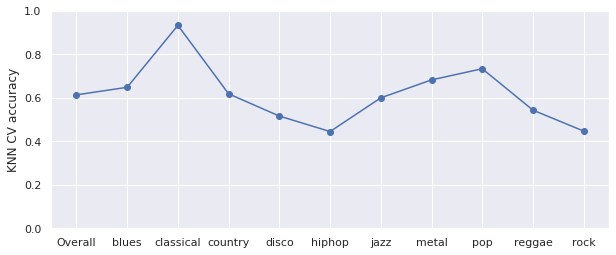

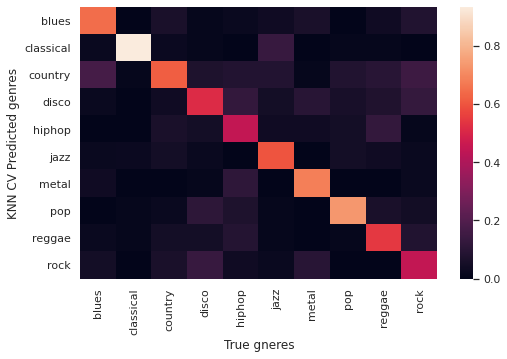

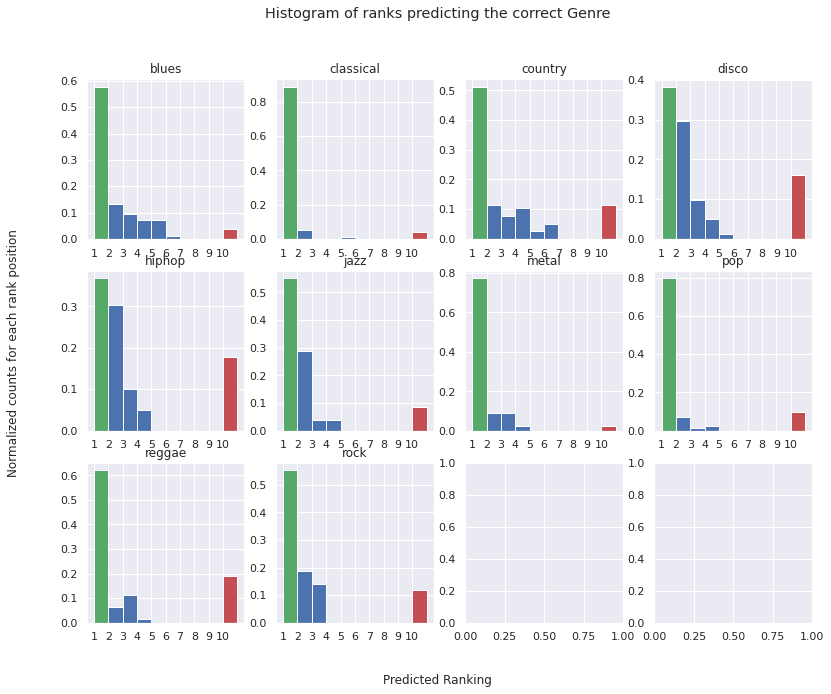

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA


X=data_mapped[params[:-1]]  # Selecting all required paramter columns here
y=data_mapped['genre']      # Selecting Genre column here

# Building a pipeline
pipe = Pipeline([('scaler',StandardScaler()),
                 #('pca',PCA(n_components = 20)),
                ('clf',KNeighborsClassifier(n_neighbors=7))])

a,b,c,d=cross_validate(X,y,pipe,'KNN');

In [ ]:
# Saving the model and few other required variables to a file

pipe_clone = clone(pipe)
pipe_clone.fit(X,y)

import pickle
with open('KNN_mfcc20.model','wb') as fh:
    pickle.dump({'model':pipe_clone,
                 'genre_mapper':genre_mapper,
                 'n_mfcc':20,
                 'columns':X.columns},fh)

### Exploring the mis-classification 
Here we select and explore in detail one of the low accuracy genre - we chose Rock


In [25]:
num_neighbors= 7
test_genre = 9
X=data_mapped[params[:-1]]
y=data_mapped['genre']
X.head()
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state = 100)
pipe = Pipeline([('scaler',StandardScaler()),
                ('clf',KNeighborsClassifier(n_neighbors=num_neighbors))])

accs=pd.DataFrame(columns=['Overall']+sorted(list(genre_mapper.keys())))
kfold = StratifiedKFold(5,shuffle=True,random_state = 440)
results = []
for train_index,test_index in kfold.split(X_train,y_train):
  X_train_train,X_train_test = X_train.iloc[train_index],X_train.iloc[test_index]
  y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]
  pipe_clone = clone(pipe)
  pipe_clone.fit(X_train_train,y_train_train)
  perd_prob = pipe_clone.predict_proba(X_train_test.loc[y_train_test == test_genre])
  results.append(perd_prob)

[0.2857142857142857, 0.0, 0.14285714285714285, 0.42857142857142855, 0.42857142857142855, 0.14285714285714285, 0.14285714285714285, 0.8571428571428571, 0.2857142857142857, 0.42857142857142855, 0.7142857142857143, 0.7142857142857143, 0.42857142857142855, 0.5714285714285714, 0.5714285714285714, 0.42857142857142855, 0.14285714285714285, 0.5714285714285714, 0.7142857142857143, 0.42857142857142855, 0.2857142857142857, 0.42857142857142855, 0.14285714285714285, 0.2857142857142857, 0.5714285714285714, 0.2857142857142857, 0.42857142857142855, 0.8571428571428571, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.42857142857142855, 0.8571428571428571, 0.7142857142857143, 0.42857142857142855, 0.7142857142857143, 0.2857142857142857, 0.14285714285714285, 0.7142857142857143, 0.14285714285714285, 0.0, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.0, 0.2857142857142857, 0.42857142857142855, 0.0, 0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.71428571428571

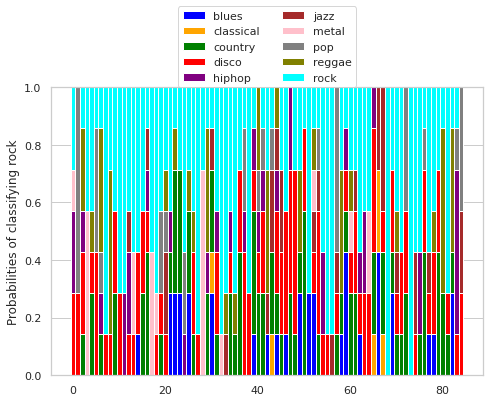

In [26]:
colors = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']
num_genres = 10
blues_probs = [S[i][0] for S in results for i in range(len(S))]
classical_probs = [S[i][1] for S in results for i in range(len(S))]
country_probs = [S[i][2] for S in results for i in range(len(S))]
disco_probs = [S[i][3] for S in results for i in range(len(S))]
hiphop_probs = [S[i][4] for S in results for i in range(len(S))]
jazz_probs = [S[i][5] for S in results for i in range(len(S))]
metal_probs = [S[i][6] for S in results for i in range(len(S))]
pop_probs = [S[i][7] for S in results for i in range(len(S))]
reggae_probs = [S[i][8] for S in results for i in range(len(S))]
rock_probs = [S[i][9] for S in results for i in range(len(S))]
print(rock_probs)
all_probs = [blues_probs,classical_probs,country_probs,disco_probs,hiphop_probs,jazz_probs,metal_probs,pop_probs,reggae_probs,rock_probs]
all_probs = [np.array(j) for j in all_probs]
ind = np.arange(sum([len(S) for S in results]))
width = 1.0
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind,blues_probs,width,color = colors[0])
ax.bar(ind,classical_probs,width,bottom = sum(all_probs[0:1]),color = colors[1])
ax.bar(ind,country_probs,width,bottom =sum(all_probs[0:2]) ,color = colors[2])
ax.bar(ind,disco_probs,width,bottom=sum(all_probs[0:3]),color = colors[3])
ax.bar(ind,hiphop_probs,width,bottom = sum(all_probs[0:4]),color = colors[4])
ax.bar(ind,jazz_probs,width,bottom = sum(all_probs[0:5]),color = colors[5])
ax.bar(ind,metal_probs,width,bottom = sum(all_probs[0:6]),color = colors[6])
ax.bar(ind,pop_probs,width,bottom = sum(all_probs[0:7]),color = colors[7])
ax.bar(ind,reggae_probs,width,bottom = sum(all_probs[0:8]),color = colors[8])
ax.bar(ind,rock_probs,width,bottom = sum(all_probs[0:9]),color = colors[9])
ax.set_ylabel('Probabilities of classifying ' + sorted(list(genre_mapper.keys()))[test_genre])
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2,labels = sorted(list(genre_mapper.keys())))
plt.show()

Now we will repreat the same process but for various other models

## Support vector machine

Cross validation accuracies:
Overall      0.680000
blues        0.734559
classical    0.932381
country      0.579167
disco        0.542647
hiphop       0.583333
jazz         0.712500
metal        0.821667
pop          0.793382
reggae       0.619167
rock         0.505882
dtype: float64
Overall accuracy on test set is  0.595


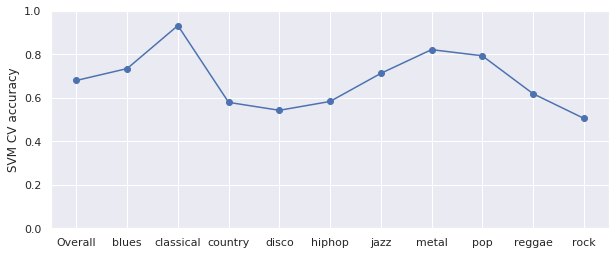

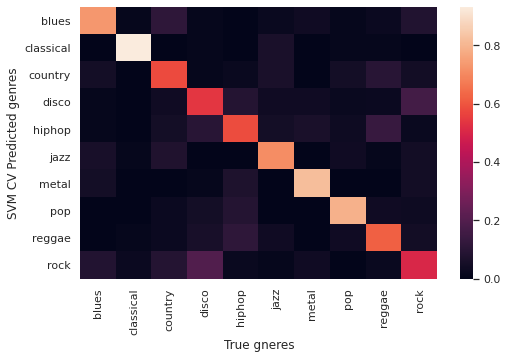

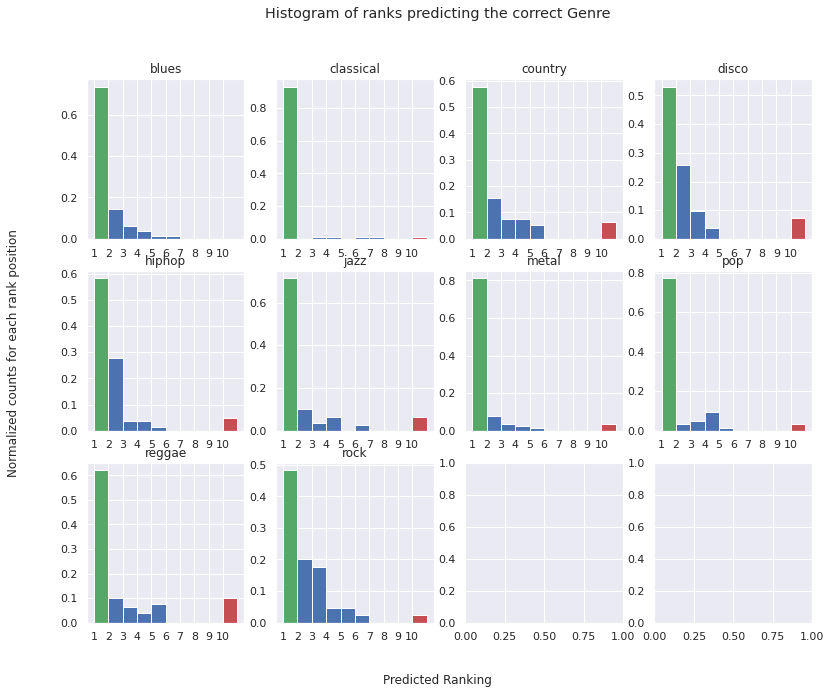

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

X=data_mapped[params[:-1]]
y=data_mapped['genre']

pipe = Pipeline([('scaler',StandardScaler()),
                 #('pca',PCA(n_components = 20)),
                ('clf',SVC(probability = True))])

cross_validate(X,y,pipe,'SVM');

## Logistic regression

Cross validation accuracies:
Overall      0.641250
blues        0.601471
classical    0.905714
country      0.490000
disco        0.602941
hiphop       0.584167
jazz         0.737500
metal        0.809167
pop          0.781618
reggae       0.480000
rock         0.447059
dtype: float64
Overall accuracy on test set is  0.58


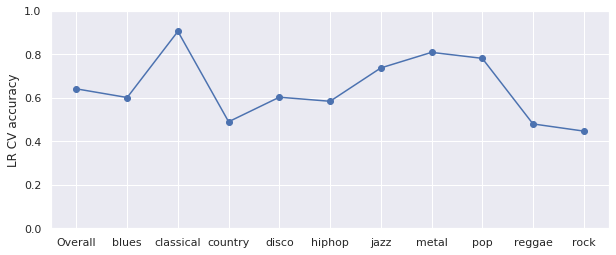

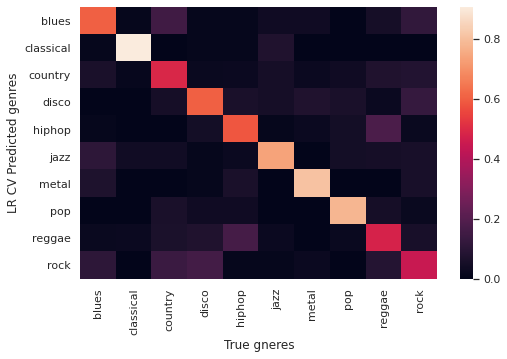

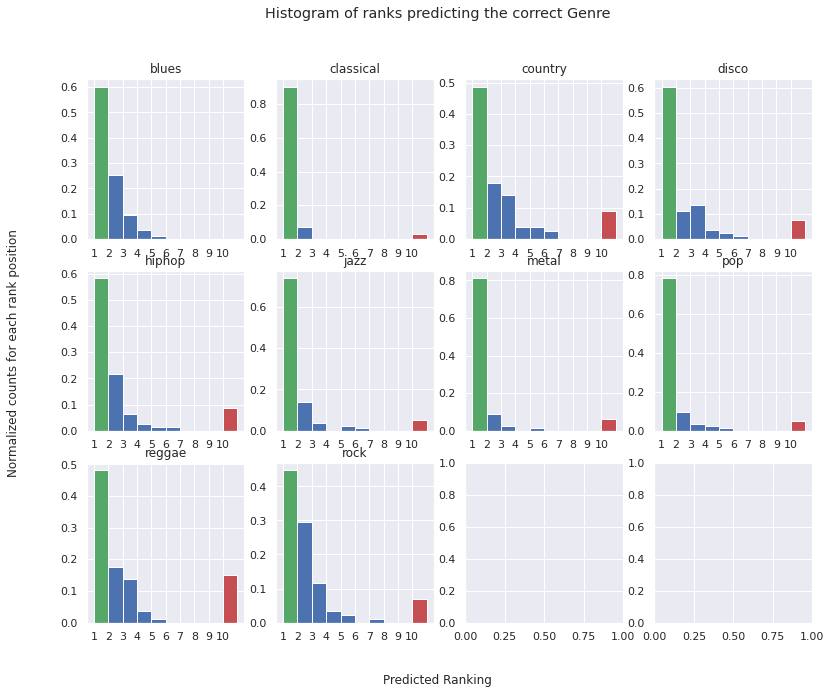

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

X=data_mapped[params[:-1]]
y=data_mapped['genre']

pipe = Pipeline([('scaler',StandardScaler()),
                 #('pca',PCA(n_components = 20)),
                ('clf',LogisticRegression(tol=0.05))])

cross_validate(X,y,pipe,'LR');

## Random forest

Cross validation accuracies:
Overall      0.573750
blues        0.671324
classical    0.823810
country      0.399167
disco        0.506618
hiphop       0.495833
jazz         0.562500
metal        0.730833
pop          0.794118
reggae       0.429167
rock         0.341176
dtype: float64
Overall accuracy on test set is  0.555


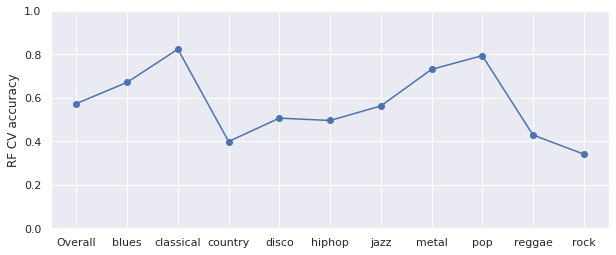

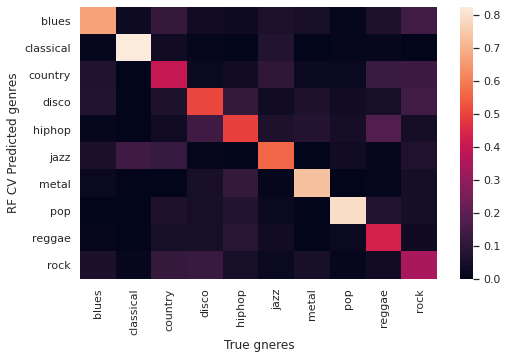

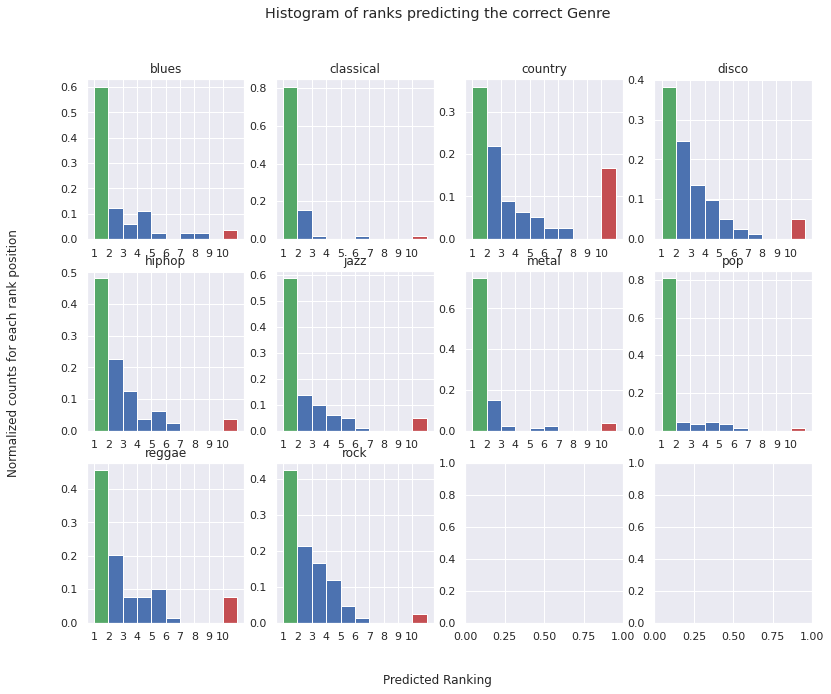

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

X=data_mapped[params[:-1]]
y=data_mapped['genre']

pipe = Pipeline([('scaler',StandardScaler()),
                 #('pca',PCA(n_components = 20)),
                ('clf',RandomForestClassifier(n_estimators=15,max_depth = 1000))])

cross_validate(X,y,pipe,'RF');

## Multilayer perceptron

Cross validation accuracies:
Overall      0.668750
blues        0.745588
classical    0.850476
country      0.580833
disco        0.616912
hiphop       0.622500
jazz         0.737500
metal        0.783333
pop          0.781618
reggae       0.454167
rock         0.529412
dtype: float64
Overall accuracy on test set is  0.66


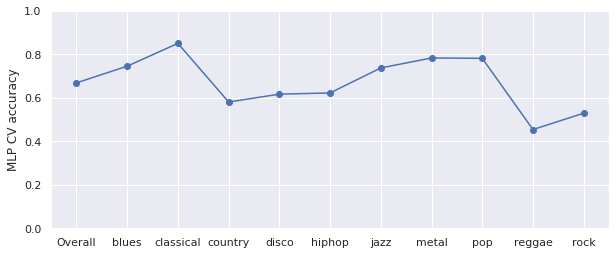

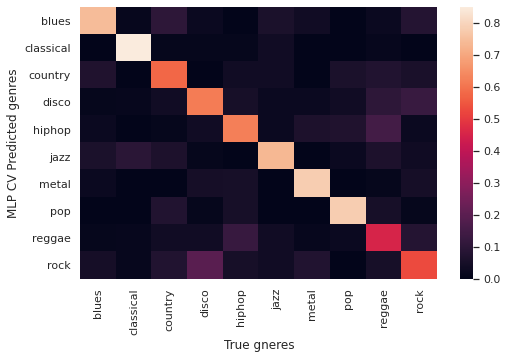

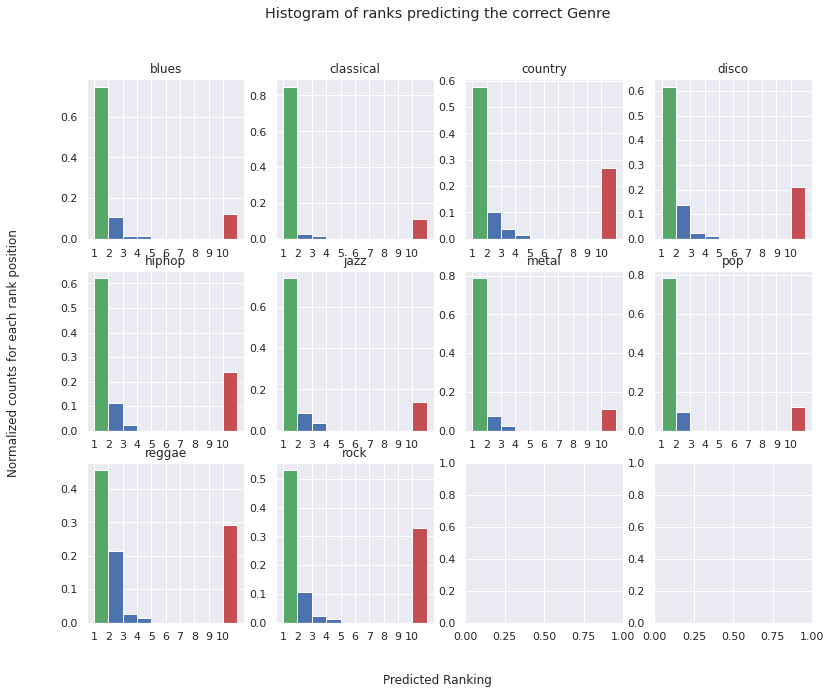

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

X=data_mapped[params[:-1]]
y=data_mapped['genre']

pipe = Pipeline([('scaler',StandardScaler()),
                 #('pca',PCA(n_components = 2)),
                 ('clf',MLPClassifier(hidden_layer_sizes=(100,100),max_iter=1000)),
                ])

cross_validate(X,y,pipe,'MLP');

In [ ]:
# Saving the model to a file

pipe_clone = clone(pipe)
pipe_clone.fit(X,y)

import pickle
with open('MLPC_mfcc20.model','wb') as fh:
    pickle.dump({'model':pipe_clone,
                 'genre_mapper':genre_mapper,
                 'n_mfcc':20,
                 'columns':X.columns},fh)

# Finalzing the model - Ensemble method: Voting calssifier

Since now we have attempted various classifiying models and comapred various metrices, we find KNN, SVM and MLP are best stuited. So, we finalize by building a voting classfier by combining all three models.

Cross validation accuracies:
Overall      0.692500
blues        0.745588
classical    0.920000
country      0.643333
disco        0.590441
hiphop       0.572500
jazz         0.775000
metal        0.784167
pop          0.769118
reggae       0.580833
rock         0.564706
dtype: float64
Overall accuracy on test set is  0.62


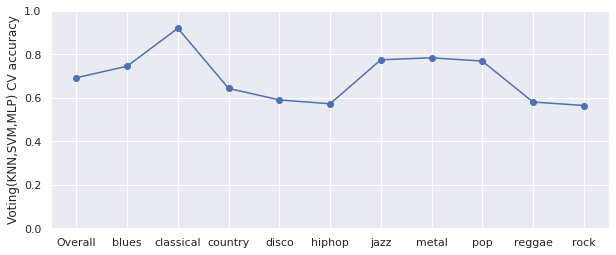

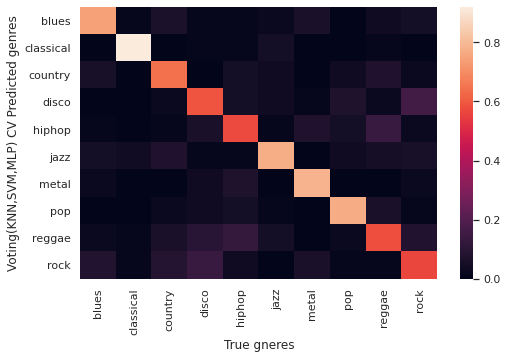

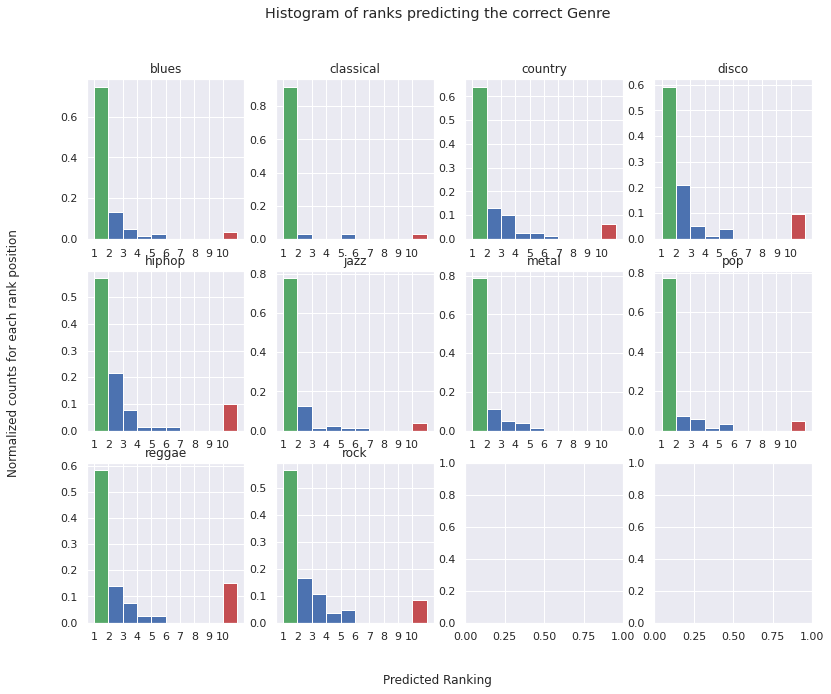

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

X=data_mapped[params[:-1]]
y=data_mapped['genre']


voting_clf = VotingClassifier(
                [
                ('knn',KNeighborsClassifier(n_neighbors = 7)),
                ('svm',SVC(probability = True)),
                ('mlp',MLPClassifier(hidden_layer_sizes=(100,100),max_iter=1000))],
                voting = "soft")

pipe = Pipeline([('scaler',StandardScaler()),
                 #('pca',PCA(n_components = 20)),
                ('clf',voting_clf)])

cross_validate(X,y,pipe,'Voting(KNN,SVM,MLP)');

In [ ]:
# Saving the model to a file

pipe_clone = clone(pipe)
pipe_clone.fit(X,y)

import pickle
with open('VoteC_mfcc20.model','wb') as fh:
    pickle.dump({'model':pipe_clone,
                 'genre_mapper':genre_mapper,
                 'n_mfcc':20,
                 'columns':X.columns},fh)